# SVMを用いた樹高推定

In [ ]:
!pip install rasterio
!pip install sat-search
!pip install intake-stac
!pip install geopandas
!pip install geojson
!pip install rioxarray
!pip install rasterstats
!pip install earthpy
# *If you use Google Colaboratery, after installing the libraries, please restart the runtime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ライブラリ読み込み
from osgeo import gdal, gdalconst, gdal_array
import os
%matplotlib inline
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
from rasterio.crs import CRS
import rioxarray as rxr
from shapely.geometry import MultiPolygon, Polygon, box
import rasterstats as rs
import earthpy.spatial as es
import earthpy.plot as ep
import random
import matplotlib.pyplot as plt
from PIL import Image
import zipfile
from fiona.crs import from_epsg
import json
import io
import requests
import intake
from satsearch import Search
plt.rcParams['figure.dpi'] = 250

## データダウンロードや前処理

5-1linear.ipynbでファイルを生成している場合には以下の処理は不要。

In [ ]:
# #画像サイズに合わせて数値を設定します
# offx = 0
# offy = 0
# cols = 4000
# rows = 7200

# # ファイルの場所は適宜変えて下さい
# tif = gdal.Open('/content/gdrive/MyDrive/playground/satBooks/shizuokaTreeHeight/Izu.tif', gdalconst.GA_ReadOnly)
# izuimg = tif.GetRasterBand(1).ReadAsArray(offx, offy, cols, rows)

# # 画像データの値に合わせて設定します
# plt.figure(figsize = (6,12))
# plt.imshow(izuimg,cmap='gray', vmin = 0, vmax = 53, interpolation = 'none')

In [ ]:
# ds = gdal.Open("/content/gdrive/MyDrive/playground/satBooks/shizuokaTreeHeight/Izu.tif")

# # reproject
# dsReprj = gdal.Warp("IzuReprj.tif", ds, dstSRS = "EPSG:32654")

# # resample 5m->10m
# # 現在の作業ディレクトリにファイルを保存
# # dsRes = gdal.Warp("IzuResMean.tif", dsReprj, xRes = 10, yRes = 10, resampleAlg = "average") # リサンプリング後の解像度 (10m)
# dsRes = gdal.Warp("IzuResNear.tif", dsReprj, xRes = 10, yRes = 10, resampleAlg = "near") # リサンプリング後の解像度 (10m)

# # visualize
# arrayOrg = dsReprj.GetRasterBand(1).ReadAsArray()
# array = dsRes.GetRasterBand(1).ReadAsArray()
# fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,18))
# ax1.imshow(arrayOrg)
# ax2.imshow(array)
# ax1.set_title('Original resolution 5m')
# ax2.set_title('Resampled resolution 10m')
# plt.show()

In [ ]:
# #樹高データ
# dsres_arr = dsRes.GetRasterBand(1).ReadAsArray()
# # print(dsres_arr) #樹高データの結果確認

# #分布を確認(ヒストグラム)
# tree_height_data = dsres_arr.flatten()

# plt.xlabel('Tree height')
# plt.ylabel('Number of pixels')
# plt.hist(tree_height_data.ravel(),30,[1,40]) # 1m以上以上40m以下
# plt.show()

In [ ]:
# # 伊豆半島に西側を関心領域に設定する
# from IPython.display import IFrame
# src = 'https://www.keene.edu/campus/maps/tool/'
# IFrame(src, width=960, height=500)

# ## Import用
# # 138.7339597, 34.9782520
# # 138.7312132, 34.8002724
# # 138.8987502, 34.8081657
# # 138.8877641, 34.9748762
# # 138.7339597, 34.9782520

In [ ]:
# aoi = [
#       [
#         138.7339597,
#         34.978252
#       ],
#       [
#         138.7312132,
#         34.8002724
#       ],
#       [
#         138.8987502,
#         34.8081657
#       ],
#       [
#         138.8877641,
#         34.9748762
#       ],
#       [
#         138.7339597,
#         34.978252
#       ]
#     ]

In [ ]:
# # 関心領域の最小緯度・経度、最大緯度・経度を取得します
# areaLon = []
# areaLat = []
# # iterating each number in list
# for coordinate in aoi:
#   areaLon.append(coordinate[0])
#   areaLat.append(coordinate[1])

# minLon = np.min(areaLon) # min longitude
# maxLon = np.max(areaLon) # max longitude
# minLat = np.min(areaLat) # min latitude
# maxLat = np.max(areaLat) # max latitude

In [ ]:
# bbox = [minLon, minLat, maxLon, maxLat] # 画像取得範囲の設定 min lon, min lat, max lon, max lat
# dates = '2020-01-01/2020-12-31'

# URL='https://earth-search.aws.element84.com/v0'
# results = Search.search(url=URL,
#                         collections=['sentinel-s2-l2a-cogs'], # sentinel-s2-l1c, sentinel-s2-l2a-cogs, sentinel-s2-l2aが指定できます
#                         datetime=dates,
#                         bbox=bbox,    
#                         sort=['<datetime'])

In [ ]:
# print('%s items' % results.found()) #検索で取得したデータ数を表示
# items = results.items()
# items.save('sentinel-s2-l2a-cogs.json') #結果はJSONへ保存

In [ ]:
# catalog = intake.open_stac_item_collection(items) #取得結果のカタログ化。画像のダウンロード用に用います
# gf = gpd.read_file('/content/sentinel-s2-l2a-cogs.json')
# # 雲量で並び替え
# gfSroted = gf.sort_values('eo:cloud_cover').reset_index(drop=True)
# gfSroted.head()

In [ ]:
# # 雲の量が最も少ない画像を取得かつ、五月のデータを取得
# item = catalog[gfSroted.id[1]]

# # 画像に含まれるデータを確認します
# # 手動でダウンロードしたものと同じバンド情報が入っていることがわかります
# print(list(item))

# # サムネイル画像の表示（RGB画像）
# thumb_url = item['thumbnail'].urlpath
# thumbImg = Image.open(io.BytesIO(requests.get(thumb_url).content))

# plt.figure(figsize=(5,5))
# plt.imshow(thumbImg)

In [ ]:
# # NDVIを作成するために赤バンドと近赤外バンドのデータを取得
# bandLists = ['B04','B08']
# file_url = [item[band].metadata['href'] for band in bandLists]
# print(file_url)

In [ ]:
# !wget --restrict-file-names=nocontrol \
#      --content-disposition \
#      --user-agent="Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:52.0) Gecko/20100101 Firefox/52.0" \
#      "https://opendata.pref.shizuoka.jp/fs/2/4/5/2/6/_/____35___.zip"

In [ ]:
# with zipfile.ZipFile('/content/合併後(35市町).zip') as zipf:
#   for zinfo in zipf.infolist():        # ZipInfoオブジェクトを取得
#       if not zinfo.flag_bits & 0x800:  # flag_bitsプロパティで文字コードを取得
#           # 文字コードが(cp437)だった場合はcp932へ変換する
#           # strオブジェクトのプロパティencode/decodeでcp932に変換
#           # 変換後のファイル名をfilenameプロパティで再度し直す
#           zinfo.filename = zinfo.filename.encode('cp437').decode('cp932')
#           if os.sep != "/" and os.sep in info.filename:
#             info.filename = info.filename.replace(os.sep, "/")

#       zipf.extract(zinfo)

In [ ]:
# # shpファイルをGeoPandasでデータフレームへ
# gdf = gpd.read_file('/content/合併後（35市町）/行政界（H23）.shp', encoding='shift_jis')
# # gdf = gdf.to_crs(crs="epsg:32654") # CRSの変更
# gdf.head()

In [ ]:
# # 松崎町、南伊豆町、西伊豆町のみを行政界データから抽出抽出
# gdfNishiIzu = gdf.loc[(gdf.ATTR_11 == '松崎町')|(gdf.ATTR_11 == '南伊豆町')|(gdf.ATTR_11 == '西伊豆町')]
# # gdfNishiIzu

# extractedGdf = gdfNishiIzu[['ATTR_7','ATTR_6','geometry']]
# extractedGdf = extractedGdf.dissolve(by='ATTR_7',aggfunc='sum')

# fig, (ax1,ax2) = plt.subplots(1,2,figsize=(6,12))
# gdfNishiIzu.plot(ax=ax1,cmap='brg')
# extractedGdf.plot(ax=ax2, cmap='brg')
# ax1.set_title('Original shape')
# ax2.set_title('Dissolved shape')
# plt.tight_layout()
# plt.show()

In [ ]:
# extractedGdf.to_file('extractedExtent.geojson',driver='GeoJSON')

## 解析データの読み込み

In [ ]:
# ファイル読み込み読み込み（パスは適宜変更）
extractedGdf = gpd.read_file('/content/drive/MyDrive/extractedExtent.geojson')
# geodataframeから、座標の最大最小を取得
x_min, y_min, x_max, y_max = extractedGdf.total_bounds
npoints = 1000 # set a sample size

random.seed(42)
allPoints = [(x,y) for x in range(int(x_min),int(x_max),500) for y in range(int(y_min),int(y_max),500)]
samplePoints = np.array(random.sample(allPoints, npoints))

x = samplePoints[:,0]
y = samplePoints[:,1]

# 取得した点ををGeoSeriesへ変換
gdf_points = gpd.GeoSeries(gpd.points_from_xy(x, y))

# ポリゴン内のデータのみを保持
gdf_points = gdf_points[gdf_points.within(extractedGdf.unary_union)]
gdf_points = gdf_points.sample(n=500) # sample 500 points
print(gdf_points)

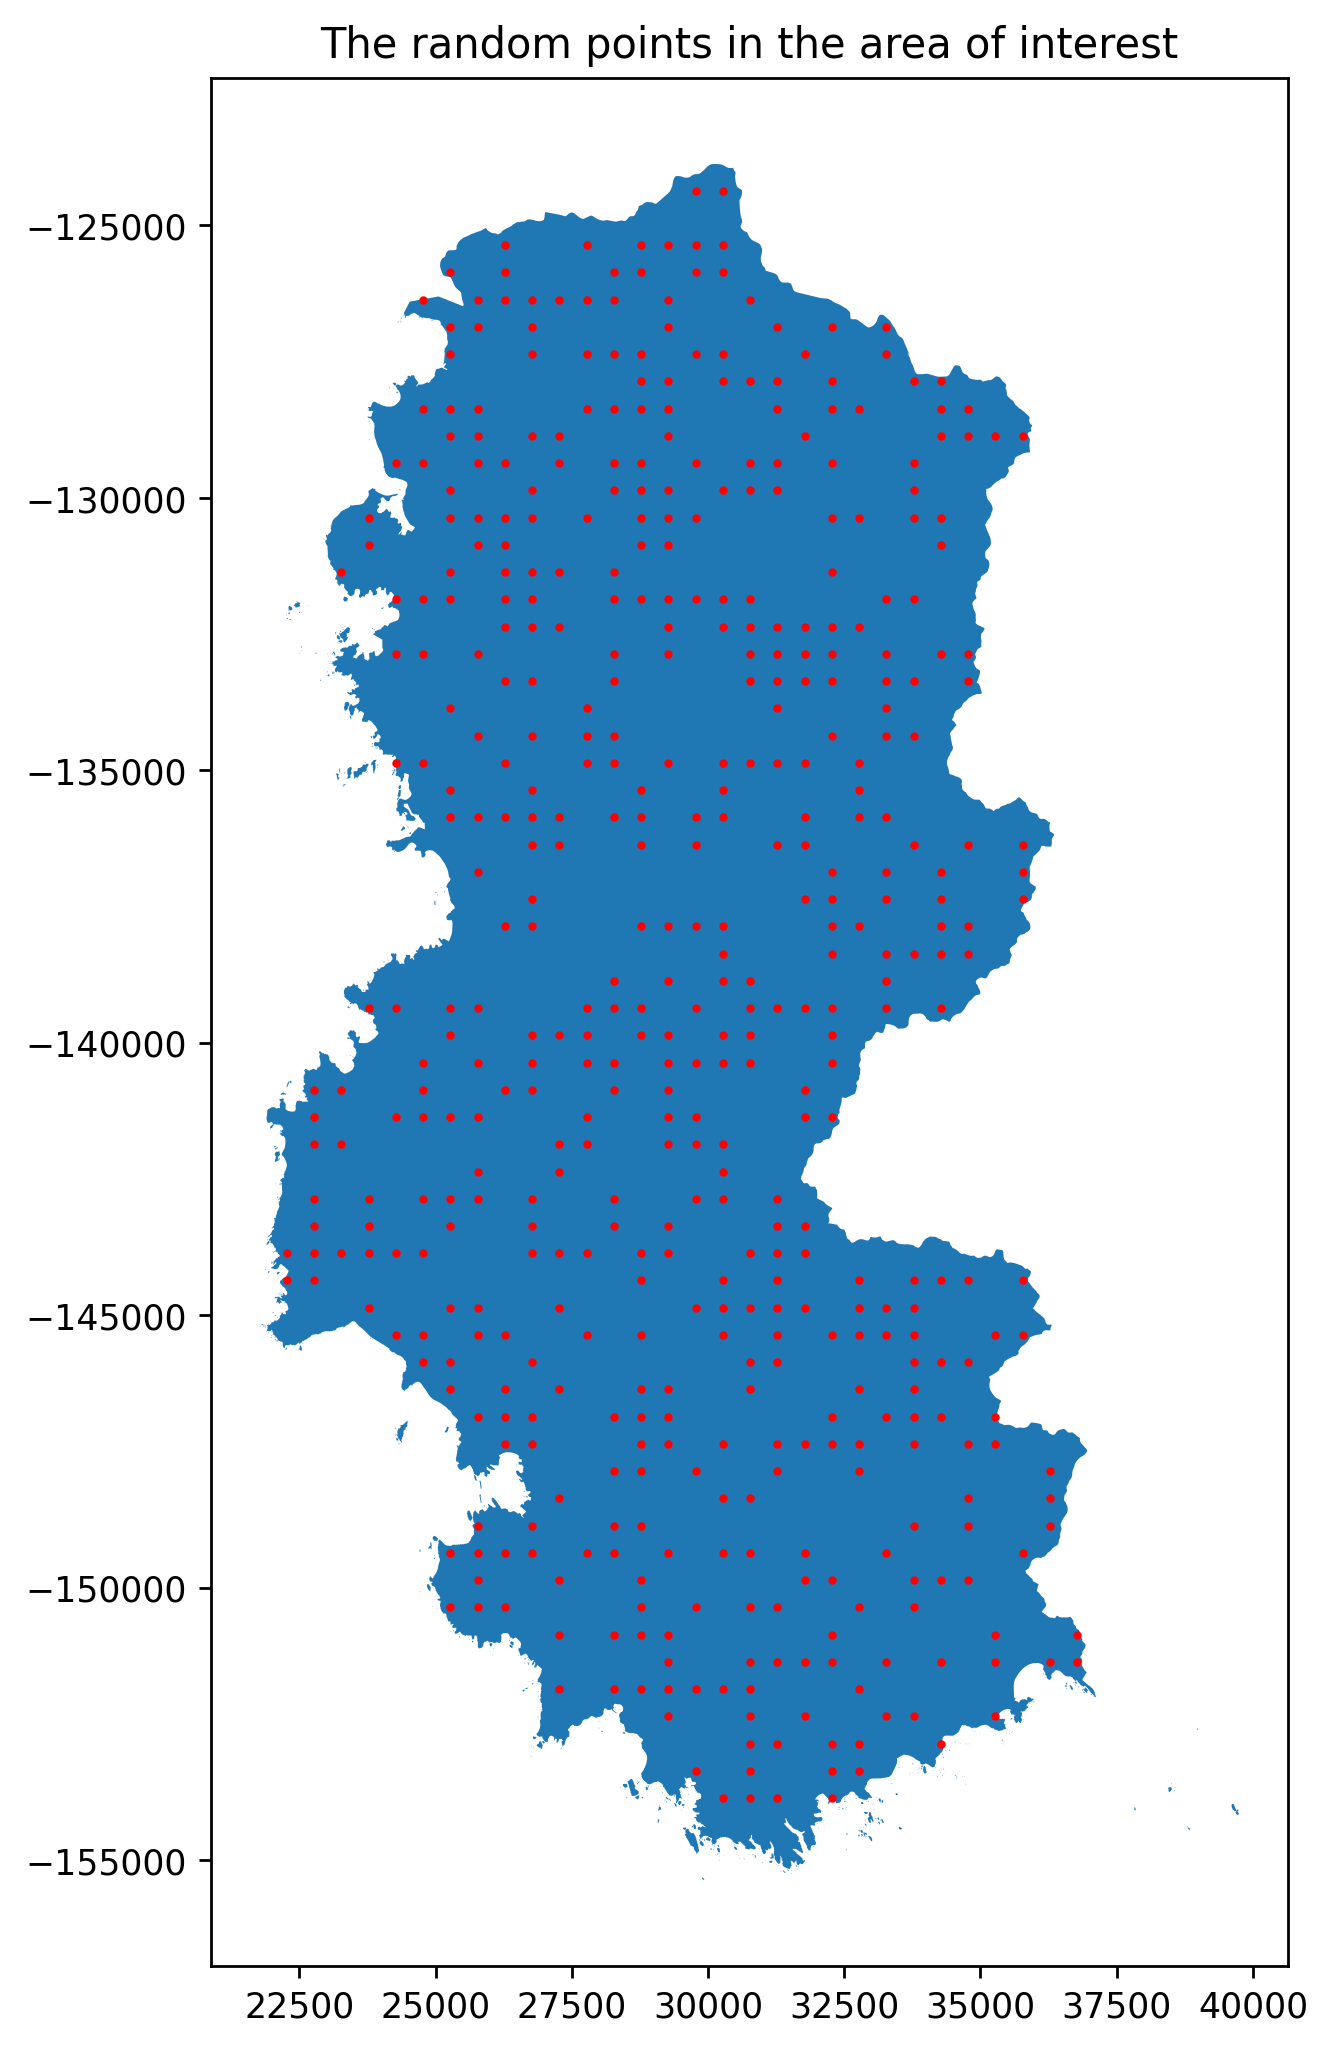

In [ ]:
fig, ax = plt.subplots(figsize=(6,10))
extractedGdf.plot(ax=ax)
gdf_points.plot(ax=ax,color='red',markersize=2)
ax.set_title('The random points in the area of interest')
plt.show()

In [ ]:
# S2の画像をクリッピング。加えてCRSの変換も行う行う

def getFeatures(gdf):
    """rasterioで読み取れる形のデータに変換するための関数"""
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

red_path = '/content/drive/MyDrive/playground/s2NDVI/rst_red_jgd.tif'
nir_path = '/content/drive/MyDrive/playground/s2NDVI/rst_nir_jgd.tif'

# 画像の読み込み
Rst_red = rxr.open_rasterio(red_path,masked=True).squeeze() # B04
Rst_nir = rxr.open_rasterio(nir_path,masked=True).squeeze() # B08
# print(Rst_red.rio.crs)

# rastrio crsオブジェクトの作成。UTM Zone54NからからJGD2000 CS VIII（平面直角座標第8系）へ変換
jgd2000N8 = CRS.from_string('EPSG:2450')

# 投影変換
Rst_red_jgd = Rst_red.rio.reproject(jgd2000N8)
Rst_nir_jgd = Rst_nir.rio.reproject(jgd2000N8)

# 画像の切り抜き処理
bbox = box(x_min, y_min, x_max, y_max)
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(2450))
coords = getFeatures(geo)
# 画像の切り抜き処理
Rst_red_clip = Rst_red_jgd.rio.clip(coords)
Rst_nir_clip = Rst_nir_jgd.rio.clip(coords)

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
# 点データとラスタデータをmatplotlibのプロット上に表示する
point_shp = gpd.GeoDataFrame(geometry=gdf_points)
fig, ax = plt.subplots(figsize=(6,6))
Rst_red_clip.plot.imshow(ax=ax,vmin=0,vmax=Rst_red_clip.quantile(0.95)) # Sentinel-2
point_shp.plot(ax=ax, color='red',markersize=5) # ポイントデータ
ax.set_title('Plot the random points overlayed on the Sentinel image')
ax.set_axis_off()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# NDVIを作成し保存
ndvi_clip = es.normalized_diff(Rst_nir_clip,Rst_red_clip)

# 結果を描画
ep.plot_bands(ndvi_clip,
              cmap='PiYG',
              scale=False,
              vmin=-1, vmax=1,
              title="Sentinel-2 Derived NDVI\n 2 May 2020")
plt.show()

Output hidden; open in https://colab.research.google.com to view.

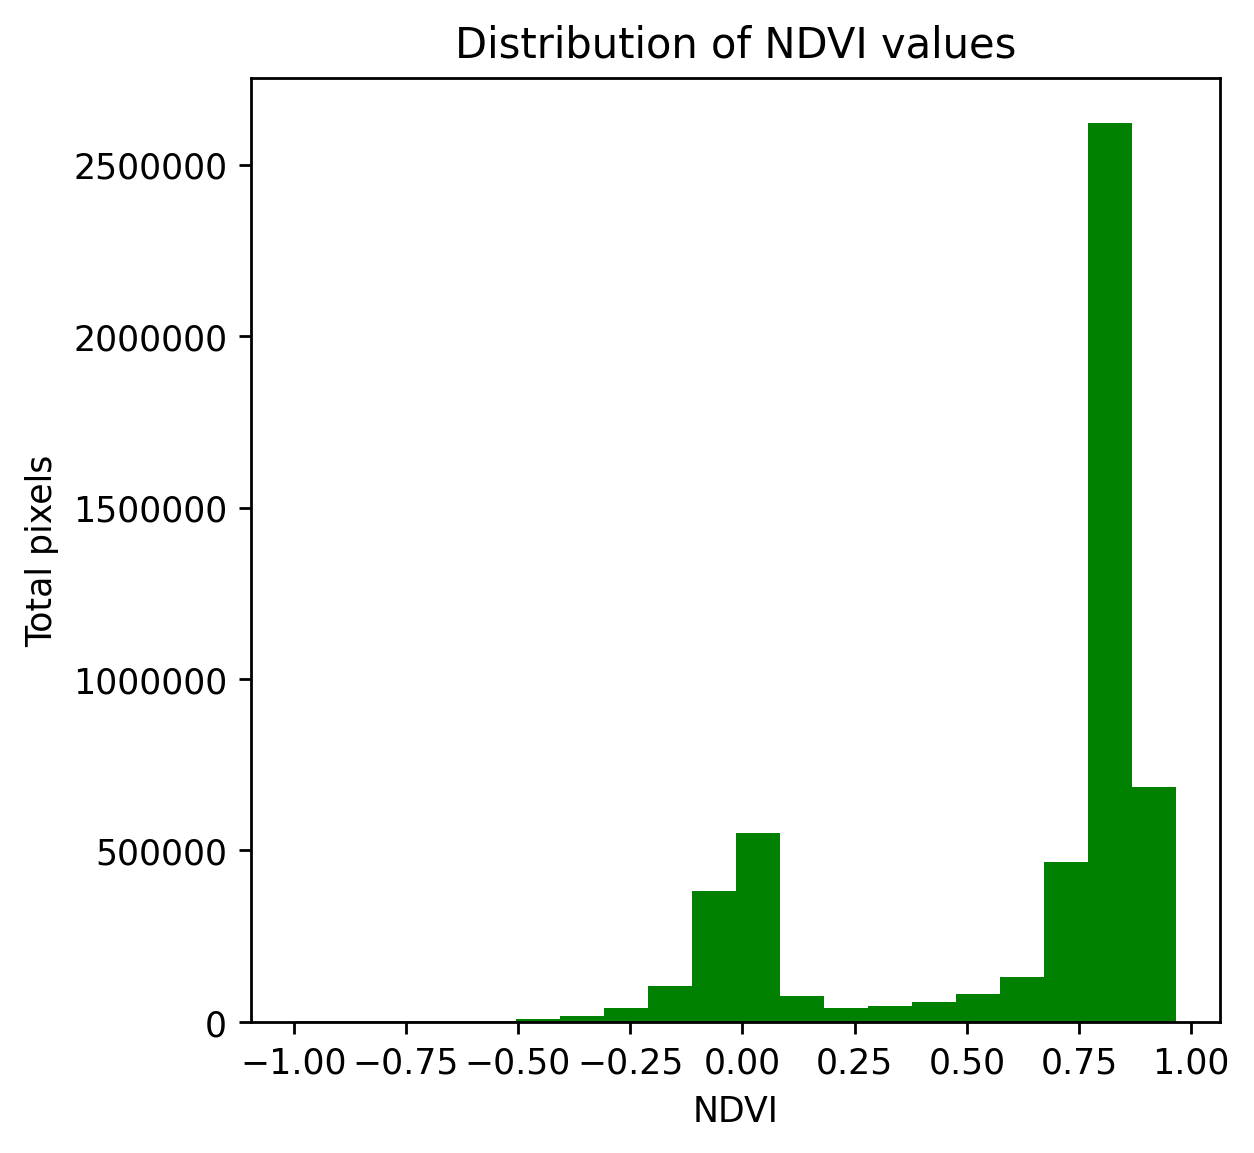

In [ ]:
# ヒストグラム作成
ax = ep.hist(ndvi_clip,
             figsize = (5,5),
             colors = 'green',
             xlabel = 'NDVI',
             ylabel = 'Total pixels',
             title = 'Distribution of NDVI values')

# 見栄え調整
ax[1].ticklabel_format(useOffset=False,
                       style='plain')

In [ ]:
from rasterstats import point_query
ndvi = (Rst_nir_clip - Rst_red_clip)/ (Rst_nir_clip + Rst_red_clip)
# print(ndvi)

pointfile = '/content/drive/MyDrive/RandomPoints2450.gpkg'
gdf_points = gpd.read_file(pointfile)

gdf_points_stats = pd.DataFrame(point_query(gdf_points, ndvi.values, \
                                            affine=ndvi.rio.transform(),nodata=-999))
gdf_points_stats.columns= ['ndvi']
ndvi_stats_df = gdf_points.join(gdf_points_stats)

# 同様の処理を樹高データに対しても行う

# データの読み込み
tree_resampled = rxr.open_rasterio('/content/drive/MyDrive/IzuResMean.tif',masked=True).squeeze()
tree_resampled_clip = tree_resampled.rio.clip(coords)

# 取得する樹木の高さを制限。最小で0mより高く、最大で40m以下とする
tree_resampled_clip_cont = tree_resampled_clip.where((tree_resampled_clip.values > 0)|(tree_resampled_clip.values <= 40),np.nan)

treeHeight_stats = pd.DataFrame(point_query(gdf_points, tree_resampled_clip_cont.values, \
                                            affine=tree_resampled_clip_cont.rio.transform(),nodata=-999))
treeHeight_stats.columns= ['tree_height']
treeHeight_stats_df = gdf_points.join(treeHeight_stats)

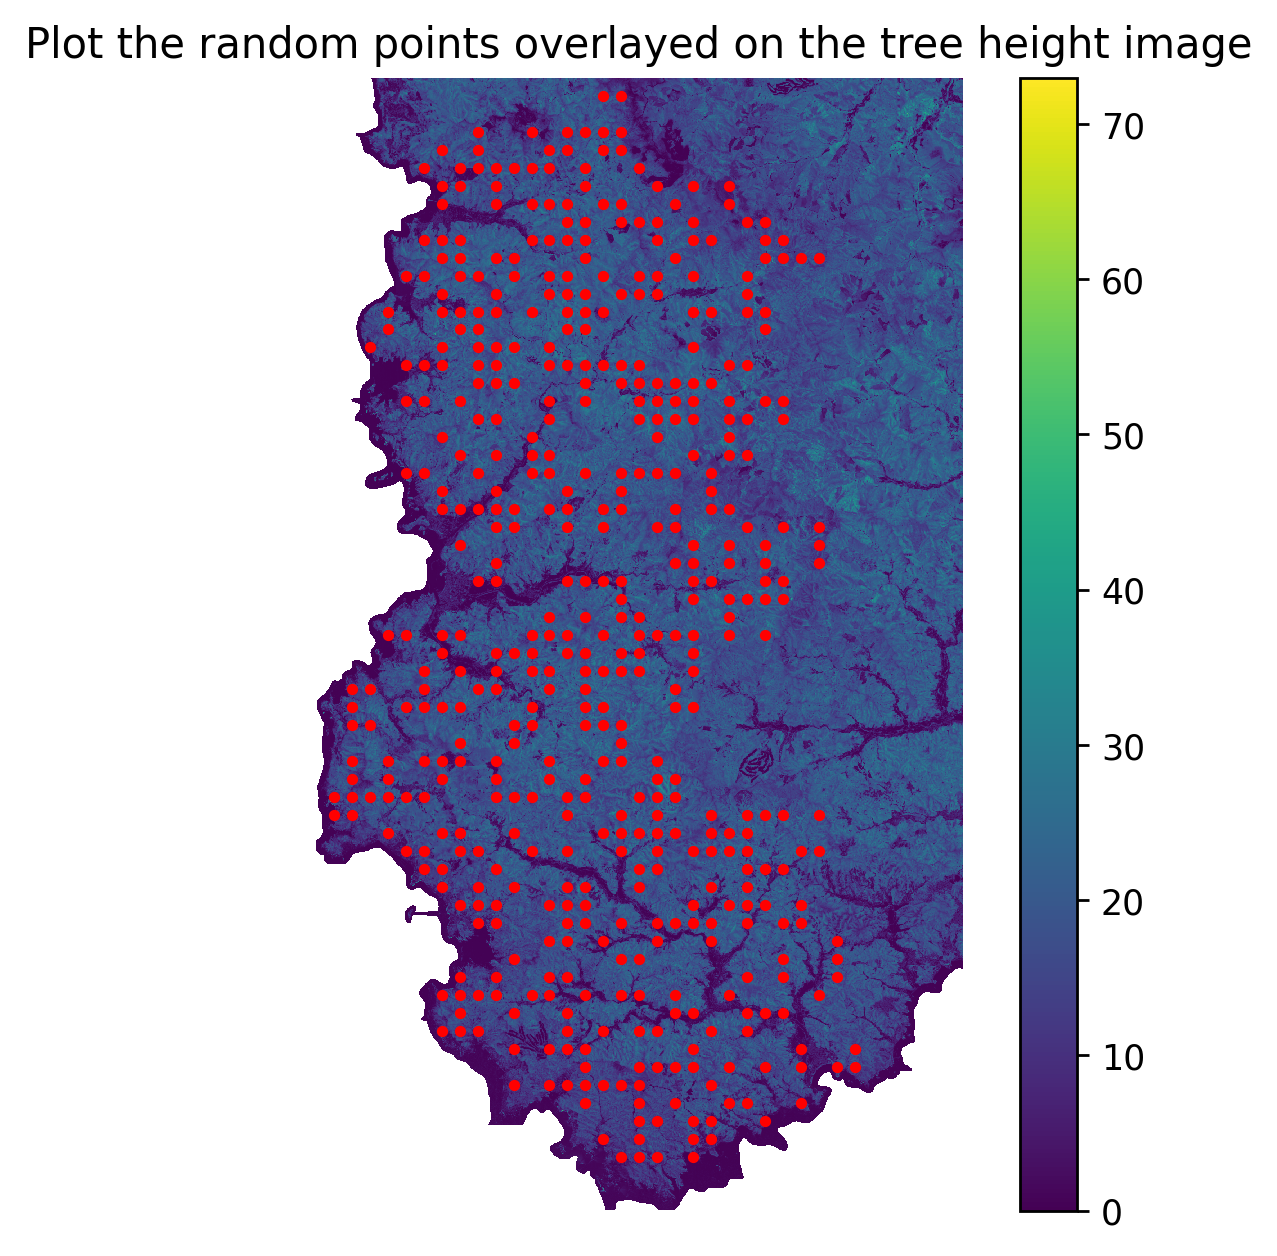

In [ ]:
# 点データとラスタデータをmatplotlibのプロット上に表示する
fig, ax = plt.subplots(figsize=(6,6))
tree_resampled_clip.plot.imshow(ax=ax)
point_shp.plot(ax=ax, color='red',markersize=5) # ポイントデータ
ax.set_title('Plot the random points overlayed on the tree height image')
ax.set_axis_off()
plt.show()

In [ ]:
# 二つのデータフレームを結合
combinedData = ndvi_stats_df.merge(treeHeight_stats_df, on='geometry')
combinedData = combinedData.dropna()

combinedData.head()

,geometry,ndvi,tree_height
0,POINT (25773.000 -142863.000),0.871716,2.279008
1,POINT (33773.000 -131863.000),0.890939,19.043671
2,POINT (26273.000 -125363.000),0.854609,11.983362
3,POINT (31273.000 -145363.000),0.842686,17.947904
4,POINT (29273.000 -151863.000),0.840863,13.737696


## SVMの実行

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from math import sqrt

# データセットをトレーニングデータとテストデータに分割
X = np.array(combinedData['ndvi']).reshape(-1,1)
y = np.array(combinedData['tree_height']).reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# shapeを使って次元を確認
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(400, 1) (100, 1) (400, 1) (100, 1)


In [ ]:
# SVMで学習
SVR = svm.SVR(gamma='auto', kernel='rbf').fit(X_train, y_train.ravel()) 
# 作成したモデルで予測
y_pred = SVR.predict(X_test)

# 予測結果の評価（決定係数）
print('r^2 test data: ', round(metrics.r2_score(y_test, y_pred),2))
# RMSE
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print('RMSE: ', round(rmse,2))

r^2 test data:  0.07
RMSE:  6.0
